In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [25]:
def read_epochs_from_dir(dir_path):
    epochs = []
    for file in os.listdir(dir_path):
        if file.endswith(".fif"):
            epochs.append(mne.read_epochs(os.path.join(dir_path, file)))
    return epochs

In [26]:
epochs = read_epochs_from_dir("/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs")

In [27]:
all_epochs = mne.concatenate_epochs(epochs)
all_epochs

Number of events,340
Events,digit 1 shown: 68digit 2 shown: 68digit 3 shown: 68digit 4 shown: 68digit 5 shown: 68
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [28]:
epochs[0]

Number of events,30
Events,digit 1 shown: 6digit 2 shown: 6digit 3 shown: 6digit 4 shown: 6digit 5 shown: 6
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


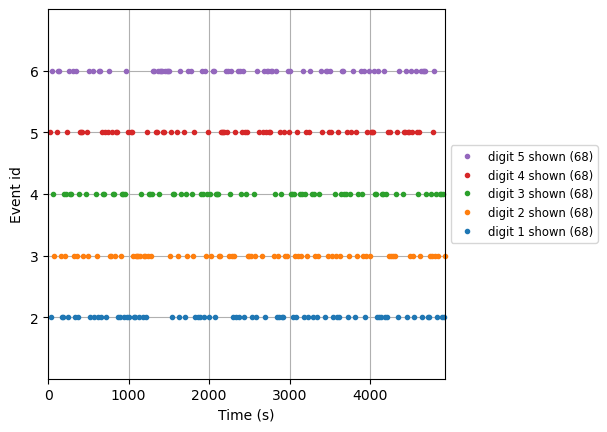

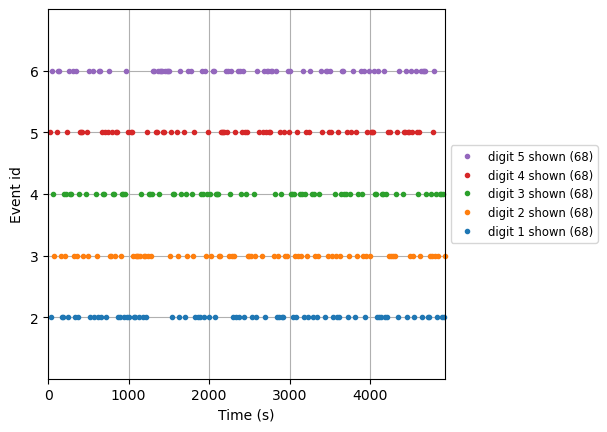

In [29]:
events = all_epochs.events

# Create an event dictionary from the epochs object
event_dict = all_epochs.event_id

# Plot the events
mne.viz.plot_events(events, event_id=event_dict, sfreq=all_epochs.info["sfreq"])

In [30]:
X = all_epochs.get_data()
y = all_epochs.events[:, 2]
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [31]:
X.shape, y.shape

((340, 16, 176), (340,))

In [32]:
np.unique(y)

array([2, 3, 4, 5, 6], dtype=int32)

In [33]:
y = y - 1

In [34]:
# import pandas as pd

# n_epochs, n_channels, n_times = X.shape

# df_X = pd.DataFrame(X.reshape(n_epochs * n_times, n_channels))

# df_y = pd.DataFrame(y, columns=['Label'])

# df_y_onehot = pd.get_dummies(df_y['Label'], prefix='Label')
# df_y_onehot = df_y_onehot.astype(int)

# df = pd.concat([df_X, df_y_onehot], axis=1)

In [35]:
def perform_grid_search(X, y):
    print("Starting the grid search process...")

    # Ensure X and y have the same number of samples
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Mismatch in number of samples: X has {X.shape[0]} samples, y has {y.shape[0]} samples")
    
    # Flatten X from (samples, channels, time points) to (samples, features)
    n_samples, n_channels, n_times = X.shape
    X_reshaped = X.reshape(n_samples, n_channels * n_times)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

    print("Standardizing the data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data standardization complete.")
    
    # Define parameter grids for different classifiers
    param_grid_svc = {
        'clf__C': [0.1, 1, 10, 100, 1000],
        'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'clf__kernel': ['linear', 'rbf', 'poly']
    }

    param_grid_rf = {
        'clf__n_estimators': [10, 50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30, 40],
        'clf__min_samples_split': [2, 5, 10]
    }

    param_grid_knn = {
        'clf__n_neighbors': [2, 3, 5, 7, 9, 11, 15, 20],
        'clf__weights': ['uniform', 'distance']
    }

    param_grid_lr = {
        'clf__C': [0.1, 1, 10, 100, 1000],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    models = {
        'SVC': (SVC(), param_grid_svc),
        'RandomForest': (RandomForestClassifier(), param_grid_rf),
        'KNeighbors': (KNeighborsClassifier(), param_grid_knn),
        # 'LogisticRegression': (LogisticRegression(max_iter=1000), param_grid_lr)
    }

    best_models = {}

    for model_name, (model, param_grid) in models.items():
        print(f"Starting grid search for {model_name}...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

    print("Grid search process complete.")
    return best_models, X_test_scaled, y_test


In [36]:
# df_X.shape, df_y_onehot.shape

In [37]:
# best_models, X_test_scaled, y_test = perform_grid_search(df_X, df_y_onehot.values)
best_models, X_test_scaled, y_test = perform_grid_search(X, y)

# Display results for each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")

Starting the grid search process...
Standardizing the data...
Data standardization complete.
Starting grid search for SVC...


Best parameters for SVC: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best cross-validation score for SVC: 0.2539393939393939
Starting grid search for RandomForest...
Best parameters for RandomForest: {'clf__max_depth': 40, 'clf__min_samples_split': 10, 'clf__n_estimators': 10}
Best cross-validation score for RandomForest: 0.26087542087542087
Starting grid search for KNeighbors...
Best parameters for KNeighbors: {'clf__n_neighbors': 2, 'clf__weights': 'distance'}
Best cross-validation score for KNeighbors: 0.23501683501683499
Starting grid search for LogisticRegression...


/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

Best parameters for LogisticRegression: {'clf__C': 0.1, 'clf__solver': 'sag'}
Best cross-validation score for LogisticRegression: 0.24666666666666665
Grid search process complete.
Accuracy for SVC: 0.2647058823529412
Accuracy for RandomForest: 0.14705882352941177
Accuracy for KNeighbors: 0.23529411764705882
Accuracy for LogisticRegression: 0.20588235294117646


/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
def create_epochs_for_digits(data_dir, output_dir=None, digit_events=('digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown'), to_ica=False, to_ica_dir="ica"):

    files = [f for f in os.listdir(data_dir) if f.endswith('.fif')]
    epochs = []
    for file in files:
        file_path = os.path.join(data_dir, file)
        raw = mne.io.read_raw_fif(file_path, preload=True)
        events = mne.find_events(raw)

        # Print found events for debugging
        print(f"Events found in file {file}: {events}")

        event_dict = {
            'digit 1 shown': 1,
            'digit 2 shown': 2,
            'digit 3 shown': 3,
            'digit 4 shown': 4,
            'digit 5 shown': 5
        }
        events, event_dict = mne.events_from_annotations(raw)

        selected_event_dict = {k: v for k, v in event_dict.items() if k in digit_events}

        try:
            epochs.append(mne.Epochs(raw, events, event_id=selected_event_dict, tmin=-0.2, tmax=0.5, baseline=(None, 0)))
        except ValueError as e:
            print(f"Error processing file {file}: {e}")
        
    return epochs

In [18]:
import mne
import numpy as np

def load_single_ica_epoch(ica_path, epoch_path, labels):
    """
    Load a single ICA and epochs file, apply ICA, and return data and labels as NumPy arrays.

    Parameters:
    ica_path (str): Path to the ICA .fif file.
    epoch_path (str): Path to the Epochs .fif file.
    labels (list of str): List of annotation labels to filter.

    Returns:
    X (numpy.ndarray): Data array.
    y (numpy.ndarray): Labels array.
    """
    # Load the ICA object
    ica = mne.preprocessing.read_ica(ica_path)
    
    # Load the epochs object
    epochs = mne.read_epochs(epoch_path, preload=True)

    # Apply ICA to epochs
    ica.apply(epochs)

    # Create a dictionary to map labels to event IDs
    label_to_event_id = {label: i+1 for i, label in enumerate(labels)}

    # Filter epochs by the specified labels
    selected_epochs = []
    selected_events = []

    for label, event_id in label_to_event_id.items():
        if label in epochs.event_id:
            epochs_for_label = epochs[label]
            selected_epochs.append(epochs_for_label)
            selected_events.append(epochs_for_label.events)
    
    if selected_epochs:
        selected_epochs = mne.concatenate_epochs(selected_epochs)
        X = selected_epochs.get_data()
        y = np.concatenate(selected_events, axis=0)[:, 2]
    else:
        X = np.array([])
        y = np.array([])

    return X, y

# ica_path = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/ica/DJ001.ica.fif'
# epoch_path = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs/DJ001.epo.fif'
# label_list = ['digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown']

# X, y = load_single_ica_epoch(ica_path, epoch_path, label_list)

# print("Data shape:", X.shape)
# print("Labels shape:", y.shape)


In [19]:
# ica_directory = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/ica'
# epochs_directory = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs'
# label_list = ['digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown']

# X, y = load_and_concat_ica_epochs(ica_directory, epochs_directory, label_list)

# print("Data shape:", X.shape)
# print("Labels shape:", y.shape)

In [68]:
def apply_ica(data):
    """
    Apply FastICA to the data.

    Parameters:
    data (numpy.ndarray): Input data array with shape (n_epochs, n_channels, n_times).

    Returns:
    ica_data (numpy.ndarray): ICA-transformed data array with the same shape as input.
    """
    n_epochs, n_channels, n_times = data.shape
    
    ica = FastICA(n_components=n_channels, random_state=0)
    
    data_2d = data.reshape(n_epochs * n_times, n_channels)
    
    ica_data_2d = ica.fit_transform(data_2d)
    
    ica_data = ica_data_2d.reshape(n_epochs, n_times, n_channels)
    
    ica_data = np.transpose(ica_data, (0, 2, 1))

    return ica_data

In [69]:
# ica_data = apply_ica(not_preprocessed_data)

# print("Original data shape:", not_preprocessed_data.shape)
# print("ICA-transformed data shape:", ica_data.shape)

In [38]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {model_name}: {accuracy}")

Test accuracy for SVC: 0.2647058823529412
Test accuracy for RandomForest: 0.14705882352941177
Test accuracy for KNeighbors: 0.23529411764705882
Test accuracy for LogisticRegression: 0.20588235294117646


Test accuracy for SVC: 0.2647058823529412
Test accuracy for RandomForest: 0.14705882352941177
Test accuracy for KNeighbors: 0.23529411764705882
Test accuracy for LogisticRegression: 0.20588235294117646


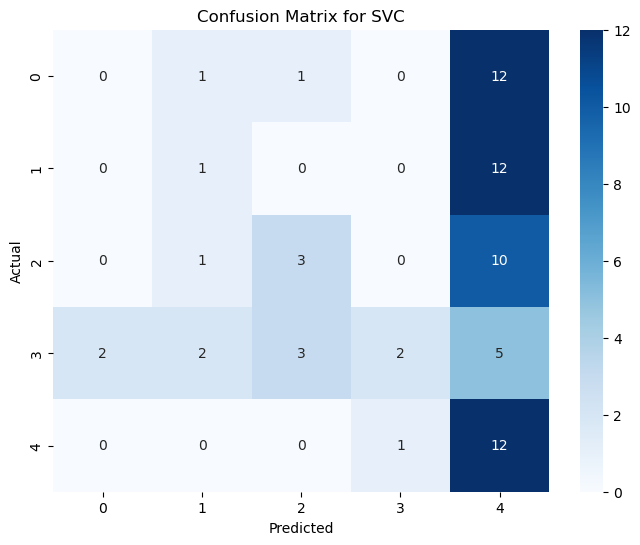

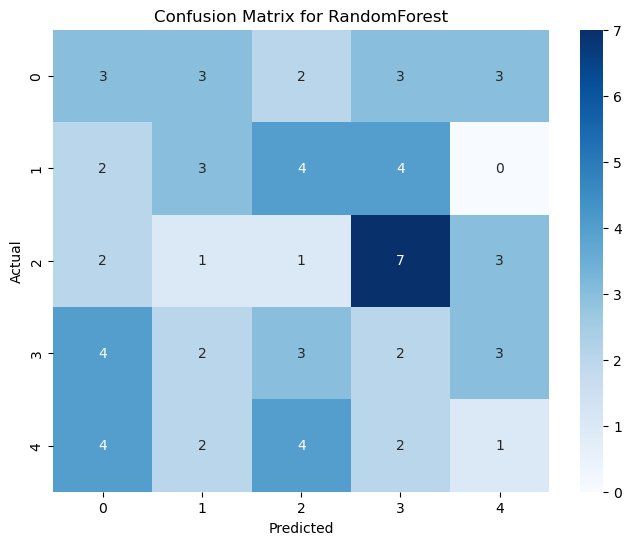

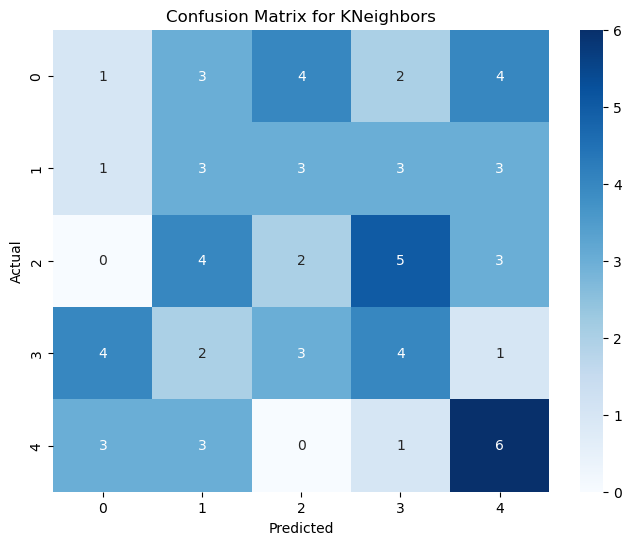

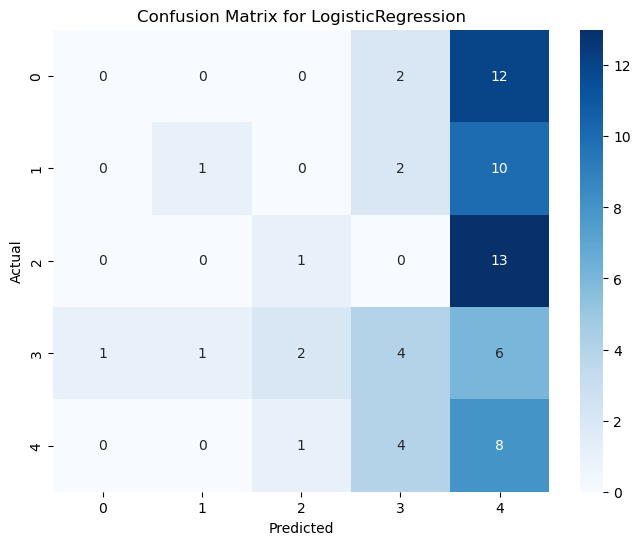

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming best_models is a dictionary of model names and their trained models
# and y_test, X_test_scaled are defined and loaded with the test data

# Store predictions and model names for plotting
model_names = []
predictions = []

# Iterate over the best_models and make predictions
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {model_name}: {accuracy}")
    model_names.append(model_name)
    predictions.append(y_pred)

# Plot confusion matrices
for model_name, y_pred in zip(model_names, predictions):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
